<a href="https://colab.research.google.com/github/SisekoC/My-Notebooks/blob/main/C1_W1_Lab_2_multi_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

In [ ]:
## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [6]:
# Define model layers.
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units=128, activation='relu')(input_layer)
second_dense = Dense(units=128, activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units=1, name='y1_output')(second_dense)
third_dense = Dense(units=64, activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units=1, name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │          1,152 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │         16,512 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 64)             │          8,256 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ y1_output (Dense)         │ (None, 1)              │            129 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ y2_output (Dense)         │ (None, 1)              │             65 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 26,114 (102.01 KB)

 Trainable params: 26,114 (102.01 KB)

 Non-trainable params: 0 (0.00 B)

None


## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [13]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [9]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 522.8791 - y1_output_root_mean_squared_error: 15.4632 - y2_output_root_mean_squared_error: 15.6318 - val_loss: 24.6349 - val_y1_output_root_mean_squared_error: 3.5219 - val_y2_output_root_mean_squared_error: 3.4973
Epoch 2/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.0713 - y1_output_root_mean_squared_error: 3.4733 - y2_output_root_mean_squared_error: 4.1015 - val_loss: 22.4656 - val_y1_output_root_mean_squared_error: 3.0831 - val_y2_output_root_mean_squared_error: 3.6000
Epoch 3/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32.3996 - y1_output_root_mean_squared_error: 3.4918 - y2_output_root_mean_squared_error: 4.4662 - val_loss: 22.9739 - val_y1_output_root_mean_squared_error: 3.2930 - val_y2_output_root_mean_squared_error: 3.4829
Epoch 4/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.1342 - y1_output_root_mean_squared_error: 3.0030 - y2_output_root_mean_squared_error: 3.6132 - val_loss: 15.6791 - val_y1

## Evaluate the Model and Plot Metrics

In [17]:
# Evaluate the model
results = model.evaluate(x=norm_test_X, y={'y1_output': test_Y[0], 'y2_output': test_Y[1]})

# Print the results
print("Results:", results)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9935 - y1_output_root_mean_squared_error: 0.4241 - y2_output_root_mean_squared_error: 0.9000 
Results: [1.0591398477554321, 0.4188246726989746, 0.9400668144226074]


In [18]:
if len(results) == 5:
    loss, Y1_loss, Y2_loss, Y1_mse, Y2_mse = results
    print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_mse, Y2_loss, Y2_mse))
else:
    print("Unexpected number of results returned:", results)

Unexpected number of results returned: [1.0591398477554321, 0.4188246726989746, 0.9400668144226074]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


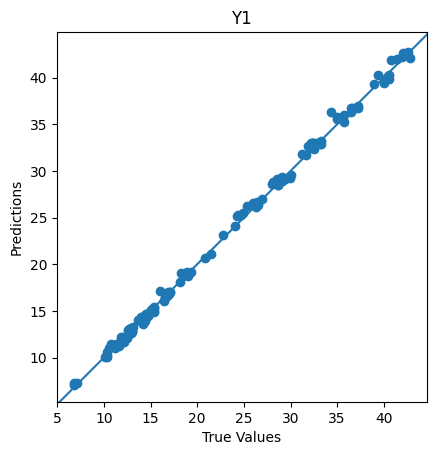

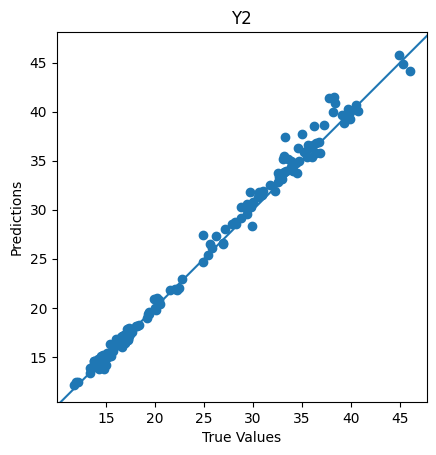

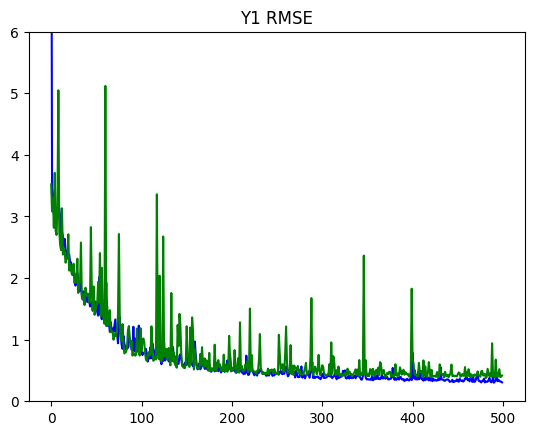

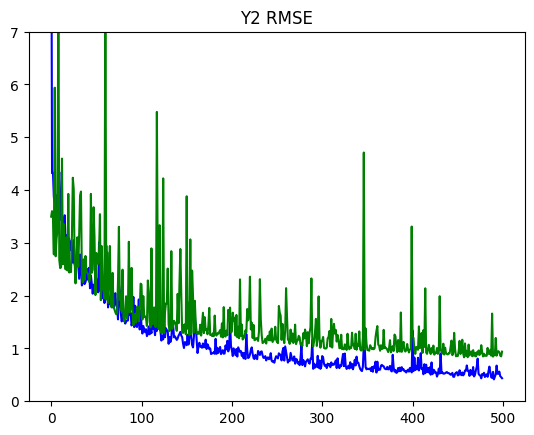

In [19]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)